# Tungsten bcc vacancy: NPT with homogeneous and inhomogeneous contributions

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import CubicSpline

# Local imports
from lammps_implicit_der import LammpsImplicitDer, SNAP
from lammps_implicit_der.tools import mpi_print, initialize_mpi, TimingGroup, plot_tools, \
                                      compute_energy_volume, create_perturbed_system
from lammps_implicit_der.systems import BccVacancy, Bcc
#from lammps_implicit_der.tools.error_tools import coord_error

plotparams = plot_tools.plotparams.copy()
plotparams['figure.figsize'] = (9, 6)
plotparams['font.size'] = 16
plotparams['figure.subplot.wspace'] = 0.2
plt.rcParams.update(plotparams)

# Create the W bcc pure and vacancy systems

In [2]:
num_cells = 2
alat = 3.18427
alat_vac = 3.163

bcc_pure = Bcc(alat=alat, num_cells=num_cells, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, num_cells=num_cells, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

print(f'{bcc_pure.Natom=}')
print(f'{bcc_pure.energy=:.3f}')
print(f'{bcc_vac.Natom=}')
print(f'{bcc_vac.energy=:.3f}')

bcc_pure.Natom=16
bcc_pure.energy=70.869
bcc_vac.Natom=15
bcc_vac.energy=69.569


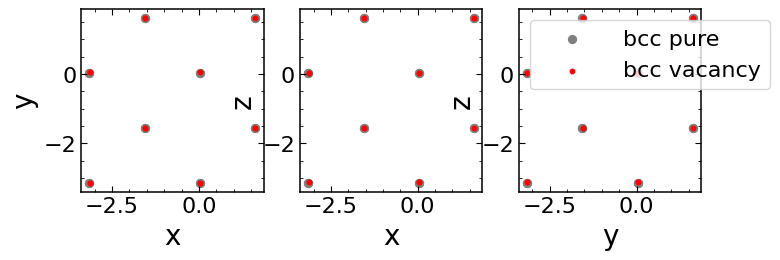

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
plot_tools.plot_coords(axes, bcc_pure.X_coord.reshape(-1, 3), c='gray', s=32, label='bcc pure')
plot_tools.plot_coords(axes, bcc_vac.X_coord.reshape(-1, 3), c='red', s=10, label='bcc vacancy')
#plt.tight_layout()
plt.show()

## Energy-volume curve

In [4]:
epsilon_array = np.linspace(-0.05, 0.05, 61)
bcc_pure_tmp = Bcc(alat=alat, num_cells=num_cells, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac_tmp = BccVacancy(alat=alat_vac, num_cells=num_cells, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

energy_array_pure, volume_array_pure, virial_array_pure, pressure_array_pure = compute_energy_volume(bcc_pure_tmp, epsilon_array)
energy_array_vac, volume_array_vac, virial_array_vac, pressure_array_vac = compute_energy_volume(bcc_vac_tmp, epsilon_array)

In [5]:
def get_min(energy_array, volume_array, pressure_array, num_cells):
    min_idx = np.argmin(energy_array)

    energy_min = energy_array[min_idx]
    volume_min = volume_array[min_idx]
    pressure_min = pressure_array[min_idx]

    alat_min = volume_min**(1/3) / num_cells

    return energy_min, volume_min, pressure_min, alat_min

energy_pure_min, volume_pure_min, pressure_pure_min, alat_pure_min = \
    get_min(energy_array_pure, volume_array_pure, pressure_array_pure, num_cells)

print('Pure bcc:')
print(f'{energy_pure_min=:.3f}')
print(f'{volume_pure_min=:.3f}')
print(f'{pressure_pure_min=:.3f}')
print(f'{alat_pure_min=:.3f}')
print('')

energy_vac_min, volume_vac_min, pressure_vac_min, alat_vac_min = \
    get_min(energy_array_vac, volume_array_vac, pressure_array_vac, num_cells)

print('Vacancy bcc:')
print(f'{energy_vac_min=:.3f}')
print(f'{volume_vac_min=:.3f}')
print(f'{pressure_vac_min=:.3f}')
print(f'{alat_vac_min=:.3f}')

Pure bcc:
energy_pure_min=0.000
volume_pure_min=258.297
pressure_pure_min=-0.003
alat_pure_min=3.184

Vacancy bcc:
energy_vac_min=0.000
volume_vac_min=253.156
pressure_vac_min=0.081
alat_vac_min=3.163


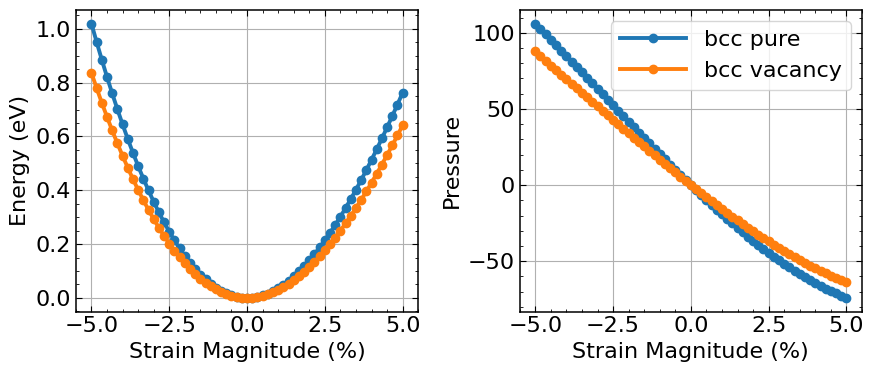

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ms = 6
axes[0].plot(100.0 * epsilon_array, energy_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[0].plot(100.0 * epsilon_array, energy_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')

axes[1].plot(100.0 * epsilon_array, pressure_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[1].plot(100.0 * epsilon_array, pressure_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Pressure')
axes[1].legend()

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

## Interpolation of virial components

In [7]:
print(f'Number of strain steps {epsilon_array.shape[0]}, number of descriptors {bcc_pure.Ndesc}')
print(f'{virial_array_pure.shape=}')

Number of strain steps 61, number of descriptors 55
virial_array_pure.shape=(61, 6, 55)


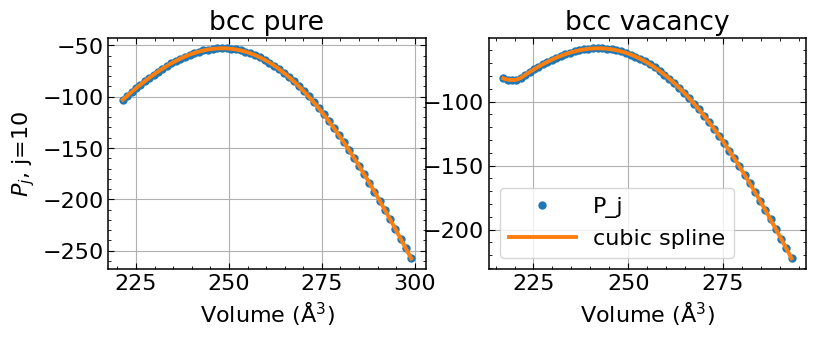

In [8]:
spline_list_pure = []
spline_list_vac = []

for idesc in range(bcc_pure.Ndesc):

    virial_trace_array_pure = np.sum(virial_array_pure[:, :3, :], axis=1) / 3.0
    spline_list_pure.append(CubicSpline(volume_array_pure, virial_trace_array_pure[:, idesc]))

    virial_trace_array_vac = np.sum(virial_array_vac[:, :3, :], axis=1) / 3.0
    spline_list_vac.append(CubicSpline(volume_array_vac, virial_trace_array_vac[:, idesc]))

vol_grid_pure = np.linspace(np.min(volume_array_pure), np.max(volume_array_pure), 1001)
vol_grid_vac = np.linspace(np.min(volume_array_vac), np.max(volume_array_vac), 1001)

j_index = 10
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(volume_array_pure, virial_trace_array_pure[:, j_index], marker='o', ls='', label='P_j', ms=5)
axes[0].plot(vol_grid_pure, spline_list_pure[j_index](vol_grid_pure), label='cubic spline', ls='-')
#axes[1].plot(vol_grid, spline_pure[j_index](vol_grid), label='dense', ls='-')

axes[1].plot(volume_array_vac, virial_trace_array_vac[:, j_index], marker='o', ls='', label='P_j', ms=5)
axes[1].plot(vol_grid_vac, spline_list_vac[j_index](vol_grid_vac), label='cubic spline', ls='-')

axes[1].legend()

axes[0].set_xlabel('Volume ($\mathrm{\AA}^3$)')
axes[1].set_xlabel('Volume ($\mathrm{\AA}^3$)')
axes[0].set_ylabel('$P_j$, '+f'j={j_index}')

axes[0].set_title('bcc pure')
axes[1].set_title('bcc vacancy')

for ax in axes:
    ax.grid()

plt.show()

## Derivative of virial

(55, 1001)


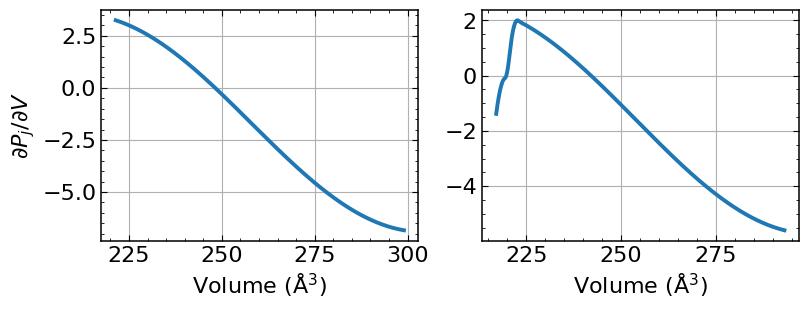

In [9]:
virial_der_pure0 = np.array([spline_list_pure[idesc](volume_pure_min, nu=1) for idesc in range(bcc_pure.Ndesc)])
virial_der_vac0 = np.array([spline_list_vac[idesc](volume_vac_min, nu=1) for idesc in range(bcc_vac.Ndesc)])

virial_der_pure_array = np.array([spline_list_pure[idesc](vol_grid_pure, nu=1) for idesc in range(bcc_pure.Ndesc)])
virial_der_vac_array = np.array([spline_list_vac[idesc](vol_grid_vac, nu=1) for idesc in range(bcc_vac.Ndesc)])

print(f'{virial_der_pure_array.shape}')

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
axes[0].plot(vol_grid_pure, virial_der_pure_array[j_index, :], label='cubic spline', ls='-')
axes[1].plot(vol_grid_vac, virial_der_vac_array[j_index, :], label='cubic spline', ls='-')
axes[0].set_ylabel('$\partial P_j / \partial V$')

for ax in axes:
    ax.grid()
    ax.set_xlabel('Volume ($\mathrm{\AA}^3$)')

plt.show()

# Perturb the potential parameters

In [10]:
# Load the Theta ens pickle file
path = '../lammps_implicit_der/data_files/'
filename = 'Theta_ens.pkl'
with open(os.path.join(path, filename), 'rb') as file:
    Theta_ens = pickle.load(file)

In [11]:
delta = 50.0
sample = 1
bcc_pure_perturb = create_perturbed_system(Theta_ens, delta, Bcc, snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                                           data_path='../lammps_implicit_der/data_files/',
                                           sample=sample, alat=alat, num_cells=num_cells, fix_box_relax=False, minimize=True)

bcc_vac_perturb = create_perturbed_system(Theta_ens, delta, BccVacancy, snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                                          data_path='../lammps_implicit_der/data_files/',
                                          sample=sample, alat=alat_vac, num_cells=num_cells, fix_box_relax=False, minimize=True)

Theta0 = bcc_pure.Theta.copy()
Theta1 = bcc_pure_perturb.Theta.copy()
dTheta = Theta1 - Theta0

## Energy-volume curves of the perturbed systems

In [12]:
energy_array_pure_pert, volume_array_pure_pert, virial_array_pure_pert, pressure_array_pure_pert = compute_energy_volume(bcc_pure_perturb, epsilon_array)
energy_array_vac_pert, volume_array_vac_pert, virial_array_vac_pert, pressure_array_vac_pert = compute_energy_volume(bcc_vac_perturb, epsilon_array)

In [13]:
energy_pure_min_pert, volume_pure_min_pert, pressure_pure_min_pert, alat_pure_min_pert = \
    get_min(energy_array_pure_pert, volume_array_pure_pert, pressure_array_pure_pert, num_cells)

print('Pure bcc perturbed:')
print(f'{energy_pure_min_pert=:.6f}')
print(f'{volume_pure_min_pert=:.3f} / {volume_pure_min=:.3f}')
print(f'{pressure_pure_min_pert=:.3f}')
print(f'{alat_pure_min_pert=:.3f} / {alat_pure_min=:.3f}')

energy_vac_min_pert, volume_vac_min_pert, pressure_vac_min_pert, alat_vac_min_pert = \
    get_min(energy_array_vac_pert, volume_array_vac_pert, pressure_array_vac_pert, num_cells)

print('\nVacancy bcc perturbed:')
print(f'{energy_vac_min_pert=:.6f}')
print(f'{volume_vac_min_pert=:.3f} / {volume_vac_min=:.3f}')
print(f'{pressure_vac_min_pert=:.3f}')
print(f'{alat_vac_min_pert=:.3f} / {alat_vac_min=:.3f}')

Pure bcc perturbed:
energy_pure_min_pert=0.000000
volume_pure_min_pert=253.166 / volume_pure_min=258.297
pressure_pure_min_pert=1.569
alat_pure_min_pert=3.163 / alat_pure_min=3.184

Vacancy bcc perturbed:
energy_vac_min_pert=0.000000
volume_vac_min_pert=244.398 / volume_vac_min=253.156
pressure_vac_min_pert=0.451
alat_vac_min_pert=3.126 / alat_vac_min=3.163


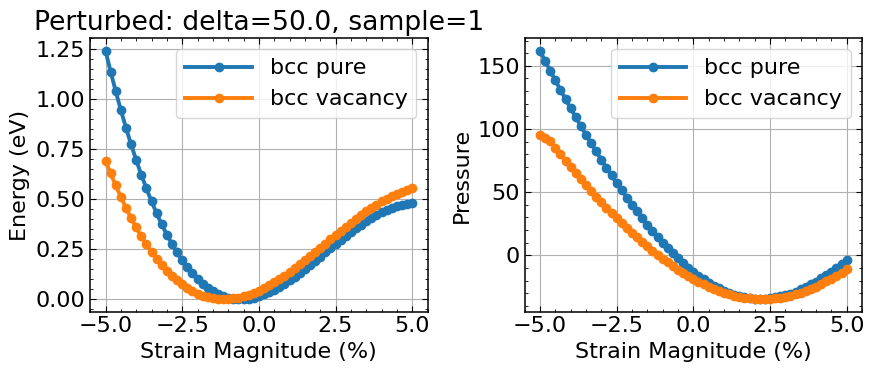

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ms = 6
axes[0].plot(100.0 * epsilon_array, energy_array_pure_pert, label='bcc pure', ls='-', marker='o', ms=ms)
axes[0].plot(100.0 * epsilon_array, energy_array_vac_pert, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')
axes[0].legend()

axes[1].plot(100.0 * epsilon_array, pressure_array_pure_pert, label='bcc pure', ls='-', marker='o', ms=ms)
axes[1].plot(100.0 * epsilon_array, pressure_array_vac_pert, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Pressure')
axes[1].legend()

axes[0].set_title(f'Perturbed: {delta=:.1f}, {sample=}')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

## Full change 1: `fix box relax` minimization

In [23]:
bcc_pure_perturb_box_relax = create_perturbed_system(Theta_ens, delta, Bcc,
                                                    snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                                                    data_path='../lammps_implicit_der/data_files/',
                                                    sample=sample, alat=alat, num_cells=num_cells, fix_box_relax=True, minimize=True)

ftol = 1e-8
algo = 'cg'
maxiter = 1000
maxeval = 1000

bcc_pure_perturb_box_relax.lmp.commands_string(f"""
    fix 1 all box/relax iso 0.0 vmax 0.1
    minimize 0 {ftol} {maxiter} {maxeval}
""")

bcc_pure_perturb_box_relax.X_coord = np.ctypeslib.as_array(bcc_pure_perturb_box_relax.lmp.gather("x", 1, 3)).flatten()
X_pure_new_full_true = bcc_pure_perturb_box_relax.X_coord.copy()
dX_pure_new_full_true = X_pure_new_full_true - bcc_pure.X_coord

vol_pure0 = bcc_pure.volume
vol_pure_new_full_true = bcc_pure_perturb_box_relax.volume

alat0 = vol_pure0**(1/3) / num_cells
alat_pure_new_full_true = vol_pure_new_full_true**(1/3) / num_cells

print(f'Pure system volume at Theta_0 {vol_pure0=:.3f}, alat {alat0=:.3f} A')
print(f'Pure system volume at Theta_1 {vol_pure_new_full_true=:.3f}, alat {alat_pure_new_full_true=:.3f} A')
print(f'alat from energy-volume curve {alat_pure_min_pert=:.3f} A')

Pure system volume at Theta_0 vol_pure0=258.297, alat alat0=3.184 A
Pure system volume at Theta_1 vol_pure_new_full_true=255.820, alat alat_pure_new_full_true=3.174 A
alat from energy-volume curve alat_pure_min_pert=3.163 A


In [16]:
bcc_vac_perturb_box_relax = create_perturbed_system(Theta_ens, delta, BccVacancy,
                                                    snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                                                    data_path='../lammps_implicit_der/data_files/',
                                                    sample=sample, alat=alat_vac, num_cells=num_cells, fix_box_relax=True, minimize=True)

ftol = 1e-8
algo = 'cg'
maxiter = 1000
maxeval = 1000

bcc_vac_perturb_box_relax.lmp.commands_string(f"""
    fix 1 all box/relax iso 0.0 vmax 0.1
    minimize 0 {ftol} {maxiter} {maxeval}
""")

X_vac_new_full_true = bcc_vac_perturb_box_relax.X_coord.copy()
dX_vac_new_full_true = X_vac_new_full_true - bcc_vac.X_coord

vol_vac0 = bcc_vac.volume
vol_vac_new_full_true = bcc_vac_perturb_box_relax.volume

alat_vac0 = vol_vac0**(1/3) / num_cells
alat_vac_new_full_true = vol_vac_new_full_true**(1/3) / num_cells

print(f'Vacancy system volume at Theta_0 {vol_vac0=:.3f}, alat {alat_vac0=:.3f} A')
print(f'Vacancy system volume at Theta_1 {vol_vac_new_full_true=:.3f}, alat {alat_vac_new_full_true=:.3f} A')
print(f'alat from energy-volume curve {alat_vac_min_pert=:.3f} A')

Vacancy system volume at Theta_0 vol_vac0=253.156, alat alat_vac0=3.163 A
Vacancy system volume at Theta_1 vol_vac_new_full_true=244.410, alat alat_vac_new_full_true=3.126 A
alat from energy-volume curve alat_vac_min_pert=3.126 A


## Inhomogeneous part only with the implicit derivative

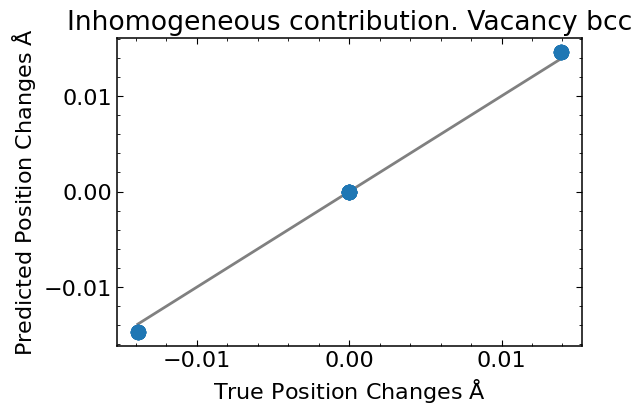

In [17]:
bcc_vac_perturb_tmp = create_perturbed_system(Theta_ens, delta, BccVacancy, snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                                          data_path='../lammps_implicit_der/data_files/',
                                          sample=sample, alat=alat_vac, num_cells=num_cells, fix_box_relax=False, minimize=True)

X_new_vac_true = bcc_vac_perturb_tmp.X_coord.copy()
dX_vac_true = bcc_vac.minimum_image(X_new_vac_true - bcc_vac.X_coord)

Theta0 = bcc_vac.Theta.copy()
Theta1 = bcc_vac_perturb_tmp.Theta.copy()
dTheta_vac = Theta1 - Theta0

dX_dTheta_vac = bcc_vac.implicit_derivative(method='inverse')
dX_vac_pred = dTheta @ dX_dTheta_vac
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

x1, x2 = dX_vac_true.min(), dX_vac_true.max()
ax.plot([x1, x2], [x1, x2], ls='-', color='gray', lw=2)
ax.plot(dX_vac_true, dX_vac_pred, marker='o', ls='')

ax.set_xlabel('True Position Changes $\mathrm{\AA}$')
ax.set_ylabel('Predicted Position Changes $\mathrm{\AA}$')
ax.set_title('Inhomogeneous contribution. Vacancy bcc')
plt.show()


## Homogeneous part only

In [18]:
def predict_volume_change(virial, virial_der, Theta_ens, delta, LammpsClass, snapcoeff_filename, alat,
                          snapparam_filename=None, data_path=None, sample=1, num_cells=2, logname='tmp.log'):

    system0 = LammpsClass(alat=alat, num_cells=num_cells, minimize=True, logname=logname,
                          data_path=data_path, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename, verbose=False)

    system1 = create_perturbed_system(Theta_ens, delta, LammpsClass, snapcoeff_filename=snapcoeff_filename, snapparam_filename=snapparam_filename,
                                      data_path=data_path, sample=sample, alat=alat, num_cells=num_cells, fix_box_relax=False, minimize=True)

    Theta0 = system0.Theta.copy()
    Theta1 = system1.Theta.copy()
    dTheta = Theta1 - Theta0

    system0.compute_virial()
    system0.gather_virial()

    virial = np.sum(system0.virial, axis=0)
    virial_trace = np.sum(virial[:3, :], axis=0) / 3.0

    delta_V_pred = - np.dot(virial_trace, dTheta) / np.dot(virial_der, Theta0)

    return delta_V_pred

In [19]:
def coord_error(X1, X2):
    """
    Error = ||X1 - X2|| / ||X1|| / N
    """
    #return np.linalg.norm(X1 - X2) / np.linalg.norm(X1) / X1.shape[0]
    return np.linalg.norm(X1 - X2)

In [20]:
delta_array = np.linspace(-25.0, 25.0, 11)
dV_pred_array = np.zeros_like(delta_array)
dV_true_array = np.zeros_like(delta_array)
coord_error_array = np.zeros_like(delta_array)
coord_error_array_hom = np.zeros_like(delta_array)
coord_error_array_inhom = np.zeros_like(delta_array)

for i, delta in enumerate(delta_array):
    print(f'{i+1}/{len(delta_array)}')

    # Unperturbed system
    system0 = BccVacancy(alat=alat_vac, num_cells=num_cells, minimize=True, logname='s0.log',
                         data_path='../lammps_implicit_der/data_files/', snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                         verbose=False)

    # For homogeneous contribution only
    system_hom = BccVacancy(alat=alat_vac, num_cells=num_cells, minimize=True, logname='s0.log',
                            data_path='../lammps_implicit_der/data_files/', snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                            verbose=False)
    # For fix box/relax
    system_pert = create_perturbed_system(Theta_ens, delta, BccVacancy,
                                      snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                                      data_path='../lammps_implicit_der/data_files/',
                                      sample=sample, alat=alat_vac, num_cells=num_cells, fix_box_relax=True, minimize=True)

    # Parameter perturbation
    Theta0 = system0.Theta.copy()
    Theta_pert = system_pert.Theta.copy()
    dTheta = Theta_pert - Theta0

    # Initial volume and lattice constant
    volume0 = system0.volume
    cell0 = system0.cell.copy()
    # TODO change name num_cells per side
    alat0 = volume0**(1/3) / num_cells
    print(f'{alat0=:.3f}')

    # True change from fix box/relax
    ftol = 1e-8
    algo = 'cg'
    maxiter = 1000
    maxeval = 1000

    # TODO consider lowering vmax to 0.001
    # TODO check in the log file get ntime step before and after minimization to see how many iterations
    # did it time out or actually converge? "Minimization stats:"

    system_pert.lmp.commands_string(f"""
        fix 1 all box/relax iso 0.0 vmax 0.001
        minimize 0 {ftol} {maxiter} {maxeval}
    """)
    volume2 = system_pert.volume
    alat2 = volume2**(1/3) / num_cells
    print(f'{alat2=:.3f}')
    # same num of atom
    dV_true_array[i] = volume2 - volume0
    # TODO implement fix box/relax as method and gather coordinates method
    system_pert.X_coord = np.ctypeslib.as_array(system_pert.lmp.gather("x", 1, 3)).flatten()
    X_coord_vac_true = system_pert.X_coord.copy()
    X_coord_vac_true -= np.mean(X_coord_vac_true)

    # Homogeneous contribution
    system0.compute_virial()
    system0.gather_virial()

    virial = np.sum(system0.virial, axis=0)
    virial_trace = np.sum(virial[:3, :], axis=0) / 3.0
    dV_pred_array[i] = - np.dot(virial_trace, dTheta) / np.dot(virial_der_vac0, Theta0)
    # TODO: change in the diag element in the supercell

    # Inhomogeneous contribution
    dX_dTheta_vac = bcc_vac.implicit_derivative(method='inverse')
    #dX_dTheta_vac = bcc_vac.implicit_derivative(method='energy', alpha=1e-4, min_style='cg')
    dX_vac_pred = dTheta @ dX_dTheta_vac

    # add coordinate changes to the initial system coordinates
    X_pred = system0.minimum_image(system0.X_coord + dX_vac_pred)
    system0.X_coord = X_pred
    system0.scatter_coord()

    X_coord_vac_inhom = system0.X_coord.copy()
    X_coord_vac_inhom -= np.mean(X_coord_vac_inhom)
    coord_error_array_inhom[i] = coord_error(X_coord_vac_true, X_coord_vac_inhom)

    # Homogeously expanded system to get the FULL contribution
    # change expand factor to strain
    expand_factor = ((volume0 + dV_pred_array[i]) / volume0)**(1/3)
    print(f'{expand_factor=:.3f}')
    cell = np.dot(cell0, np.eye(3) * expand_factor)
    #M = np.diag([1.0-expand_factor]*3)
    #cell = np.dot(cell0, (np.eye(3) - M))
    system0.apply_strain(cell)
    system0.get_cell()
    alat_new = system0.volume**(1/3) / num_cells
    print(f'{alat_new=:.3f}')

    system0.X_coord = np.ctypeslib.as_array(system0.lmp.gather("x", 1, 3)).flatten()
    X_coord_vac_pred = system0.X_coord.copy()
    X_coord_vac_pred -= np.mean(X_coord_vac_pred)
    coord_error_array[i] = coord_error(X_coord_vac_true, X_coord_vac_pred)

    # Homogeneous contribution only
    system_hom.apply_strain(cell)
    X_coord_vac_hom = system_hom.X_coord.copy()
    X_coord_vac_hom -= np.mean(X_coord_vac_hom)
    coord_error_array_hom[i] = coord_error(X_coord_vac_true, X_coord_vac_hom)

    volume1 = system_hom.volume
    alat1 = volume1**(1/3) / num_cells
    print(f'{alat1=:.3f}')

    print('')

    #plot_coords = True
    plot_coords = False

    if plot_coords:
        fig, axes = plt.subplots(1, 3, figsize=(8, 4))
        plot_tools.plot_coords(axes, X_coord_vac_hom.reshape(-1, 3), c='gray', s=32, label='pred. hom')
        plot_tools.plot_coords(axes, X_coord_vac_true.reshape(-1, 3), c='red', s=15, label='true')
        plot_tools.plot_coords(axes, X_coord_vac_pred.reshape(-1, 3), c='blue', s=7, label='pred. full')
        #plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        x1, x2 = X_coord_vac_true.min(), X_coord_vac_true.max()
        ax.plot([x1, x2], [x1, x2], ls='-', color='gray', lw=2)
        ax.plot(X_coord_vac_true, X_coord_vac_pred, marker='o', ls='', label='pred. full')
        ax.plot(X_coord_vac_true, X_coord_vac_hom, marker='o', ls='', label='pred. hom')
        ax.plot(X_coord_vac_true, X_coord_vac_inhom, marker='o', ls='', label='pred. inhom')
        ax.set_xlim(0.89,0.91)
        ax.set_ylim(0.89,0.91)
        ax.legend()
        ax.set_xlabel('True Position Changes ($\mathrm{\AA})$')
        ax.set_ylabel('Predicted Position Changes ($\mathrm{\AA}$)')
        plt.show()


1/11
alat0=3.163
alat2=3.178
expand_factor=1.005
alat_new=3.180
alat1=3.180

2/11
alat0=3.163
alat2=3.175
expand_factor=1.004
alat_new=3.176
alat1=3.176

3/11
alat0=3.163
alat2=3.172
expand_factor=1.003
alat_new=3.173
alat1=3.173

4/11
alat0=3.163
alat2=3.169
expand_factor=1.002
alat_new=3.170
alat1=3.170

5/11
alat0=3.163
alat2=3.166
expand_factor=1.001
alat_new=3.166
alat1=3.166

6/11
alat0=3.163
alat2=3.163
expand_factor=1.000
alat_new=3.163
alat1=3.163

7/11
alat0=3.163
alat2=3.160
expand_factor=0.999
alat_new=3.160
alat1=3.160

8/11
alat0=3.163
alat2=3.157
expand_factor=0.998
alat_new=3.156
alat1=3.156

9/11
alat0=3.163
alat2=3.153
expand_factor=0.997
alat_new=3.153
alat1=3.153

10/11
alat0=3.163
alat2=3.149
expand_factor=0.996
alat_new=3.150
alat1=3.150

11/11
alat0=3.163
alat2=3.146
expand_factor=0.995
alat_new=3.146
alat1=3.146



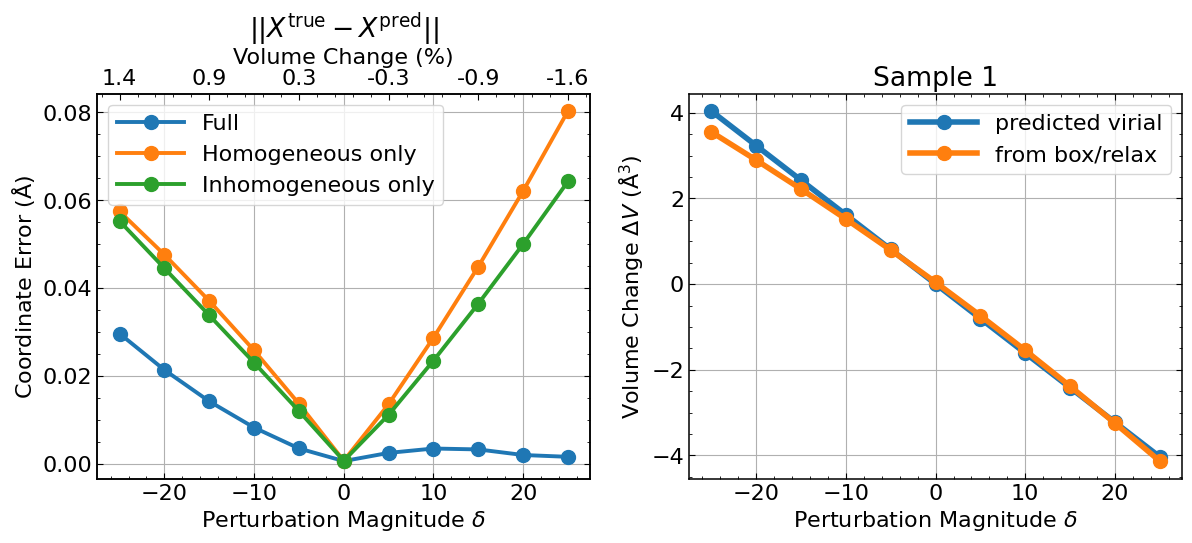

In [24]:
dV_perc_array = (dV_true_array) / volume0 * 100.0

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(delta_array, coord_error_array, marker='o', ls='-', label='Full')
axes[0].plot(delta_array, coord_error_array_hom, marker='o', ls='-', label='Homogeneous only')
axes[0].plot(delta_array, coord_error_array_inhom, marker='o', ls='-', label='Inhomogeneous only')
axes[0].legend()
axes[0].set_xlabel('Perturbation Magnitude $\delta$')
axes[0].set_ylabel('Coordinate Error ($\mathrm{\AA}$)')
axes[0].set_title(r'$||X^{\mathrm{true}} - X^{\mathrm{pred}}||$')
axes[0].grid()
# second x axis. For each delta from main x-axis, the corresponding volume change in percent
ax2 = axes[0].twiny()
ax2.set_xlim(axes[0].get_xlim())
ntick = 2
ax2.set_xticks(delta_array[::ntick])
ax2.set_xticklabels(f'{dV:.1f}' for dV in dV_perc_array[::ntick])
ax2.set_xlabel('Volume Change (%)')
ax2.set_xlabel('Volume Change (%)')



axes[1].plot(delta_array, dV_pred_array, label='predicted virial', lw=4.0, marker='o', ms=10)
axes[1].plot(delta_array, dV_true_array, label='from box/relax', lw=4.0, marker='o', ms=10)
axes[1].set_title(f'Sample {sample}')
axes[1].set_xlabel('Perturbation Magnitude $\delta$')
axes[1].set_ylabel('Volume Change $\Delta V$ ($\mathrm{\AA}^3$)')
axes[1].grid()
axes[1].legend()

plt.show()

## Full change 2: Implicit derivative with `fix box/relax`

In [26]:
delta = 10
sample = 1

system0 = BccVacancy(alat=alat_vac, num_cells=num_cells, minimize=True, logname='s0.log',
                        data_path='../lammps_implicit_der/data_files/', snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                        verbose=False)


# For fix box/relax
system_pert = create_perturbed_system(Theta_ens, delta, BccVacancy,
                                    snapcoeff_filename='W_NEW.snapcoeff', snapparam_filename='W_NEW.snapparam',
                                    data_path='../lammps_implicit_der/data_files/',
                                    sample=sample, alat=alat_vac, num_cells=num_cells, fix_box_relax=True, minimize=True)

dX_dTheta_vac_full = system0.implicit_derivative(method='energy', alpha=1e-4, min_style='cg')

In [ ]:
# Predicted position changes with dX_dTheta_vac_full
Theta0 = system0.Theta.copy()
Theta_pert = system_pert.Theta.copy()
dTheta = Theta_pert - Theta0

dX_vac_pred_full = dTheta @ dX_dTheta_vac_full

X_pred = system0.X_coord + dX_vac_pred_full
system0.scatter_coord

In [27]:
# minimize the system_pert
ftol = 1e-8
algo = 'cg'
maxiter = 1000
maxeval = 1000

system_pert.lmp.commands_string(f"""
    fix 1 all box/relax iso 0.0 vmax 0.001
    minimize 0 {ftol} {maxiter} {maxeval}
""")
volume2 = system_pert.volume
alat2 = volume2**(1/3) / num_cells
system_pert.X_coord = np.ctypeslib.as_array(system_pert.lmp.gather("x", 1, 3)).flatten()
X_coord_vac_true = system_pert.X_coord.copy()
X_coord_vac_true -= np.mean(X_coord_vac_true)